## Importing Packages

In [1]:
#importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import tensorflow_hub as hub
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2022-07-27 11:33:45.866764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 11:33:45.866797: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Here we create a variable to hold the path to our traning and validation data

In [2]:
# creating path to data
train_path = 'Tomatoes/train'
valid_path = 'Tomatoes/val'

In [3]:
#Image shape and batch size variables
IMG_SHAPE = 224
batch_size = 50

Here we create a function that performs data Agumentation to our training data set

- first we rescale the image to be between -1 and 1 
- rotate the image to 45 degree angle
- flip the image horizontally
- Zoom the image 15%

In [4]:
#function that handles data Agumentation
def data_agument():
    image_gen_train = ImageDataGenerator(rescale=1./255, rotation_range=45,\
                                         width_shift_range=.15,height_shift_range=.15,\
                                         horizontal_flip=True,zoom_range=0.15)
    return image_gen_train

In [5]:
#classes of tomatoes leaf list
classes = ['tomatoes_Bacterial_spot','tomatoes_Early_blight','tomatoes_Late_blight', 'tomatoes_Leaf_Mold',
        'tomatoes_Septoria_leaf_spot','tomatoes_Spider_mites Two-spotted_spider_mite',
        'tomatoes_Target_Spot','tomatoes_Tomato_Yellow_Leaf_Curl_Virus','tomatoes_Tomato_mosaic_virus','tomatoes_healthy']

Applying the `data_agument` function to the training dataset, using `flow_from_directory` to load the data to disk.

- Setting the data batch size 
- directory to load the data from
- Setting shuffle to true (to shuffle the Images)
- Setting the specified target size for Images
- Setting the list of classes and class mode

In [6]:
#using flow from directory to load data to disk
train_data_gen = data_agument().flow_from_directory(
                batch_size=batch_size,
                directory=train_path,
                shuffle=True,
                target_size=(IMG_SHAPE,IMG_SHAPE),
                classes=classes,
                class_mode='sparse'
                )

Found 10000 images belonging to 10 classes.


Based on the above output we have 10000 images belonging to 10 classes, which are the 9 disease classes, and one healthy class.

 Each class of tomato leaf has 1000 images for the training dataset

- tomatoes_Bacterial_spot
- tomatoes_Early_blight 
- tomatoes_Late_blight  
- tomatoes_Leaf_Mold
- tomatoes_Septoria_leaf_spot
- tomatoes_Spider_mites Two-spotted_spider_mite
- tomatoes_Target_Spot 
- tomatoes_Tomato_Yellow_Leaf_Curl_Virus
- tomatoes_Tomato_mosaic_virus
- tomatoes_healthy

Here we used the `ImageDataGenerator` to rescale the validation data and then load the data to disk using `flow_from_directory`, we do not apply the `data_agument` function here, bacause the validation data agumentation is not required for the validation dataset

In [7]:
#validation data
image_gen_val = ImageDataGenerator(rescale=1./255)

valid_data_gen = image_gen_val.flow_from_directory(
                batch_size=batch_size,
                directory=valid_path,
                shuffle=False,
                target_size=(IMG_SHAPE,IMG_SHAPE),
                classes=classes,
                class_mode='sparse'
                )

Found 1000 images belonging to 10 classes.


After loading the validation data into disk, It appears we have 1000 Images belonging to 10 classes, each class has 100 Images for the validation data.

In [8]:
#tomatoes class labels
train_data_gen.class_indices

{'tomatoes_Bacterial_spot': 0,
 'tomatoes_Early_blight': 1,
 'tomatoes_Late_blight': 2,
 'tomatoes_Leaf_Mold': 3,
 'tomatoes_Septoria_leaf_spot': 4,
 'tomatoes_Spider_mites Two-spotted_spider_mite': 5,
 'tomatoes_Target_Spot': 6,
 'tomatoes_Tomato_Yellow_Leaf_Curl_Virus': 7,
 'tomatoes_Tomato_mosaic_virus': 8,
 'tomatoes_healthy': 9}

The `.class_indices` function display each class of data with it's corresponding label in a dictionary format

In [9]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Applying the `plotImages` function to plot some Images from the dataset

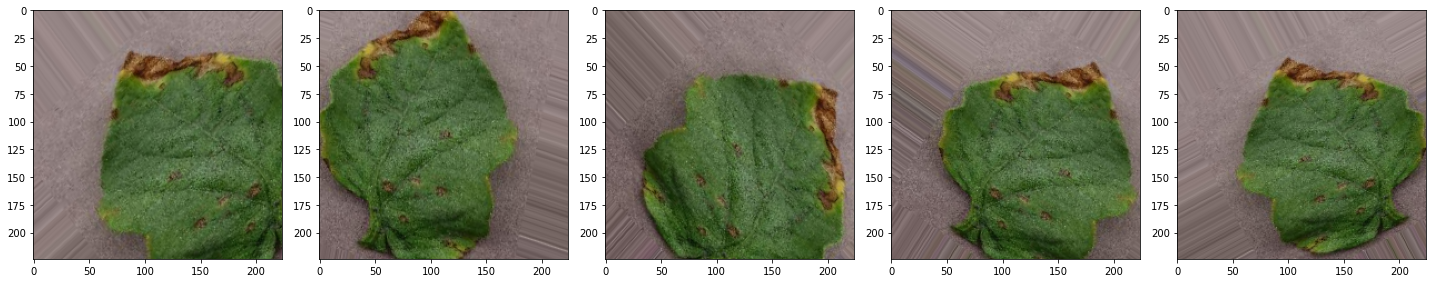

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Building CNN Sequential Model

The Model we Building is a `Sequentail model` which is a layer stack of layers

The first layers is the Conv2D layer. These is convolution layers that will deal with our input images, which are seen as 2-dimensional matrices.
The secound layer is Maxpooling layer which applies Maxpooling to the images with a pool size of 3 x 3 and a stride of 2

32 in the first layer and 64 in the thried layer are the number of nodes in each layer. This number can be adjusted to be higher or lower, depending on the size of the dataset. In our case, 64 and 32 work well, so we will stick with that.

The Kernel size is the size of the filter matrix for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix.

The activation function we will be using for our first 4 layers is the `ReLU`, or Rectified Linear Activation. This activation function has been proven to work well in neural networks.

The first layer also takes in an input shape. This is the shape of each input image, (224,224, 3), with the 3 signifying that the images are colored `(RGB)`

Between the Conv2D layers and the dense layer, there is a `Flatten` layer. Flatten serves as a connection between the convolution and dense layers

`Dense` is the layer type we will use in for our output layer. Dense is a standard layer type that is used in many cases for neural networks.

We will have 10 nodes in our output layer, one for each possible outcome (0–9).

The activation is `softmax`. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability

In [9]:
#Building CNN Sequential model from scratch

num_label = 10  #setting the number of labels

model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),  #the Conv2D layer with the input shape
    MaxPool2D(pool_size=(3, 3), strides=2),                                                  #Maxpooling layer with a 2 x 2 matrix and a stride of 2
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    
    Flatten(),                                                                              #flatten layer to convert 2D array into single long continuous linear vector 1D array
    
    Dense(512, activation='relu'),                                                          #fully connected dense layer with 512 nodes
    Dense(num_label, activation='softmax')                                                  #final dense layer with number of output and activation function of softmax
])

2022-07-27 11:34:16.161037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-27 11:34:16.161127: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-27 11:34:16.161191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-07-27 11:34:16.164036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 32)       0

### Compiling the Model

Next up, we need to compile our model. Compiling the model takes three parameters: optimizer, loss and metrics.

The optimizer controls the learning rate. We will be using `adam` as our optmizer. The adam optimizer adjusts the learning rate throughout training.

The learning rate determines how fast the optimal weights for the model are calculated. A smaller learning rate may lead to more accurate weights (up to a certain point), but the time it takes to compute the weights will be longer.

We will use `sparse_categorical_crossentropy` for our loss function. This is the most common used for classification. A lower score indicates that the model is performing better.

We are using accuracy metric to see the score on the validation dataset during training

In [11]:
#model compiling
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Model Training

Next, we use the `.fit` function to fit the model with the training dataset and at the same see the score on the validation with the validation dataset.

Here we are training the model for 20 Epochs and setting verbose to 2 to display the output as the model trains

The number of epochs is the number of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. After that point, the model will stop improving during each epoch.

In [ ]:
# model training
history = model.fit(train_data_gen, 
    steps_per_epoch = len(train_data_gen),
    validation_data = valid_data_gen,
    validation_steps = len(valid_data_gen),
    epochs = 20, verbose = 2
)

Epoch 1/20
200/200 - 428s - loss: 1.5066 - accuracy: 0.4545 - val_loss: 1.4255 - val_accuracy: 0.5770 - 428s/epoch - 2s/step
Epoch 2/20
200/200 - 427s - loss: 0.7136 - accuracy: 0.7445 - val_loss: 1.0463 - val_accuracy: 0.6820 - 427s/epoch - 2s/step
Epoch 3/20
200/200 - 425s - loss: 0.5342 - accuracy: 0.8054 - val_loss: 1.5543 - val_accuracy: 0.6300 - 425s/epoch - 2s/step
Epoch 4/20
200/200 - 425s - loss: 0.4318 - accuracy: 0.8481 - val_loss: 1.2066 - val_accuracy: 0.6920 - 425s/epoch - 2s/step
Epoch 5/20
200/200 - 425s - loss: 0.3518 - accuracy: 0.8750 - val_loss: 1.3195 - val_accuracy: 0.6270 - 425s/epoch - 2s/step
Epoch 6/20
200/200 - 424s - loss: 0.3179 - accuracy: 0.8848 - val_loss: 0.4224 - val_accuracy: 0.8640 - 424s/epoch - 2s/step
Epoch 7/20
200/200 - 424s - loss: 0.2629 - accuracy: 0.9084 - val_loss: 0.8075 - val_accuracy: 0.7820 - 424s/epoch - 2s/step
Epoch 8/20
200/200 - 424s - loss: 0.2631 - accuracy: 0.9066 - val_loss: 0.7852 - val_accuracy: 0.8000 - 424s/epoch - 2s/step


After re-runing the Sequential Model a few time's and applying some changes, The model validation accuracy goes high from about 72% to 88% accuracy

### Plotting the Sequential Model Accuracy

Next we will be ploting the accuracy metric of the Sequential model the training accuracy agains the validation accuracy and also the training loss agains the validation accuracy.

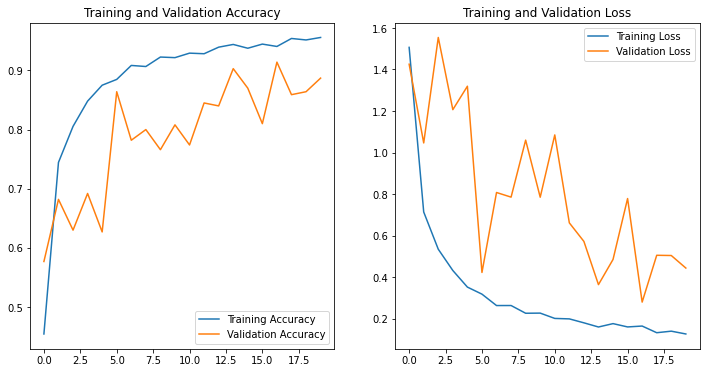

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
#valid_data_gen.classes

In [15]:
# model prediction
predictions = model.predict(x=valid_data_gen, steps=len(valid_data_gen), verbose=0)

In [16]:
np.round(predictions[0:10])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [19]:
predictions = np.argmax(predictions, axis=1)

In [20]:
print(classification_report(valid_data_gen.labels, predictions, target_names = classes))

                                               precision    recall  f1-score   support

                      tomatoes_Bacterial_spot       1.00      0.80      0.89       100
                        tomatoes_Early_blight       0.70      0.95      0.81       100
                         tomatoes_Late_blight       0.95      0.87      0.91       100
                           tomatoes_Leaf_Mold       0.96      0.90      0.93       100
                  tomatoes_Septoria_leaf_spot       0.87      0.93      0.90       100
tomatoes_Spider_mites Two-spotted_spider_mite       0.90      0.80      0.85       100
                         tomatoes_Target_Spot       0.91      0.91      0.91       100
       tomatoes_Tomato_Yellow_Leaf_Curl_Virus       0.95      0.94      0.94       100
                 tomatoes_Tomato_mosaic_virus       0.89      0.80      0.84       100
                             tomatoes_healthy       0.86      0.97      0.91       100

                                     accu

## Applying Transfer Learning with Mobilenet_V2

Transfer Learning is the process reusing a pre-trained model on new set of data.
The model uses the knowledge learned from a prior assignment to increase prediction about a new task in transfer learning.

MobileNet V2 model was developed at Google, pre-trained on the ImageNet dataset with 1.4M images and 1000 classes of web images. We will use this as our base model to train with our dataset and classify the images of tomato leafs

In [12]:
#mobilenet_v2 model url
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
mobile_net = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

Setting the `layer.trainable` to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training (either when training with fit() or when training with any custom loop that relies on `trainable_weights` to apply gradient updates).

In [13]:
#Freezing the variables in the feature extractor layer, so that the training only modifies the final classifier layer
mobile_net.trainable = False

Here we build up the mobileNet model into tensorflow sequential

In [14]:
#building the transfer learning model
mobile_net_model = tf.keras.Sequential([
    mobile_net,
    Dense(10)
])

#model summary
mobile_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


### Compiling the transfer learning model

In [15]:
#compiling the model
mobile_net_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10
history = mobile_net_model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=valid_data_gen)

Epoch 1/10
200/200 [==============================] - 238s 1s/step - loss: 1.0667 - accuracy: 0.6581 - val_loss: 0.7917 - val_accuracy: 0.7470
Epoch 2/10
200/200 [==============================] - 231s 1s/step - loss: 0.5882 - accuracy: 0.8139 - val_loss: 0.6936 - val_accuracy: 0.7620
Epoch 3/10
200/200 [==============================] - 230s 1s/step - loss: 0.4974 - accuracy: 0.8449 - val_loss: 0.5972 - val_accuracy: 0.7940
Epoch 4/10
200/200 [==============================] - 233s 1s/step - loss: 0.4281 - accuracy: 0.8643 - val_loss: 0.5933 - val_accuracy: 0.8080
Epoch 5/10
200/200 [==============================] - 233s 1s/step - loss: 0.4040 - accuracy: 0.8730 - val_loss: 0.5205 - val_accuracy: 0.8180
Epoch 6/10
200/200 [==============================] - 229s 1s/step - loss: 0.3850 - accuracy: 0.8758 - val_loss: 0.5317 - val_accuracy: 0.8100
Epoch 7/10
200/200 [==============================] - 227s 1s/step - loss: 0.3616 - accuracy: 0.8808 - val_loss: 0.4840 - val_accuracy: 0.8180

After Training the model, we now have validation accuracy of 81% accuracy

### Plotting Model Accuracy

Next we will be ploting the accuracy metric of the mobileNet model the training accuracy agains the validation accuracy and also the training loss agains the validation accuracy.

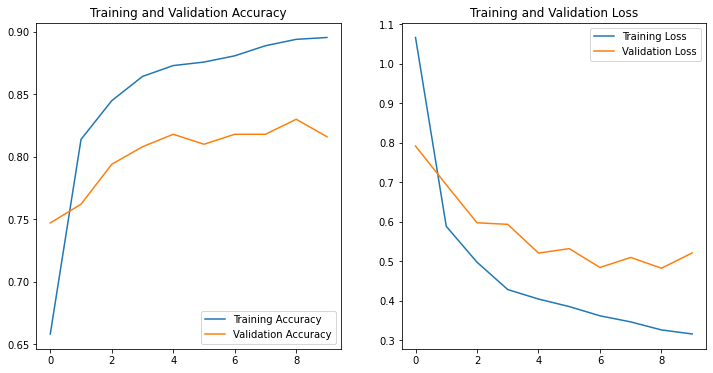

In [16]:
#plotting training vs validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Applying prediction to the MobileNet Model

Here we will be using the transfer learning model for prediction on validation dataset 

In [18]:
model_prediction = mobile_net_model.predict(x=valid_data_gen, steps=len(valid_data_gen), verbose=0)

In [19]:
y_val = valid_data_gen.labels
model_prediction = np.argmax(model_prediction, axis=1)

MobileNet Model Classification Report

In [20]:
print(classification_report(y_val, model_prediction, target_names = classes, digits= 4 ))

                                               precision    recall  f1-score   support

                      tomatoes_Bacterial_spot     0.8544    0.8800    0.8670       100
                        tomatoes_Early_blight     0.9808    0.5100    0.6711       100
                         tomatoes_Late_blight     0.8000    0.9200    0.8558       100
                           tomatoes_Leaf_Mold     0.6866    0.9200    0.7863       100
                  tomatoes_Septoria_leaf_spot     0.7404    0.7700    0.7549       100
tomatoes_Spider_mites Two-spotted_spider_mite     0.9383    0.7600    0.8398       100
                         tomatoes_Target_Spot     0.6364    0.8400    0.7241       100
       tomatoes_Tomato_Yellow_Leaf_Curl_Virus     0.9794    0.9500    0.9645       100
                 tomatoes_Tomato_mosaic_virus     0.9333    0.7000    0.8000       100
                             tomatoes_healthy     0.8505    0.9100    0.8792       100

                                     accu

### Saving model
Here we save the model and export the model pickle file and the model weights

In [16]:
import pickle 
# Save the trained model as a pickle string.
pickle.dump(mobile_net_model, open('mobile_net_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://bb707a6e-a887-43f8-b3cf-1e93228868dd/assets


INFO:tensorflow:Assets written to: ram://bb707a6e-a887-43f8-b3cf-1e93228868dd/assets


Saving the model to `.h5` extension saves

- The architecture of the model
- The weights of the model
- The training configuration (loss and optimizer)
- The state of the optimizer, allowing to resume training where you left off.

In [21]:
#if model not saved to disk
import os.path
if os.path.isfile('mobile_net_model.h5') is False:
    mobile_net_model.save('mobile_net_model.h5')

In [25]:
#Sequential model
import os.path
if os.path.isfile('Sq_model.h5') is False:
    model.save('Sq_model.h5')

Saving the model to `.json` will only save the model artchictecture

In [19]:
# serialize model to json
json_model = mobile_net_model.to_json()

In [27]:
#Sequential model serialize model to json
Sq_json_model = model.to_json()

In [20]:
#save the MobileNet model architecture to JSON file
with open('mobile_net_model.json', 'w') as json_file:
    json_file.write(json_model)

In [30]:
#save the Sequential model architecture to JSON file
with open('Sq_model.json', 'w') as json_file:
    json_file.write(Sq_json_model)

Here we only save the model weights

In [24]:
#saving MobileNet model weights
mobile_net_model.save_weights("weights.h5")

In [31]:
#saving Sequential model weights
model.save_weights("Sq_weights.h5")

### Loading Saved Model and making prediction on a Single Image

After saving the model in the prevoiusly step, Here we reload the model and applied prediction on the model we saved previously

In [9]:
# load json and create model
from tensorflow.keras.models import Sequential, model_from_json

json_file = open('mobile_net_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={'KerasLayer':hub.KerasLayer})

# load weights into new model
loaded_model.load_weights("model_weights.h5", by_name=True)
print("Loaded model from disk")

2022-07-16 16:55:38.798502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-16 16:55:38.798539: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-16 16:55:38.798563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-07-16 16:55:38.799944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded model from disk


In [10]:
#making prediction on model
y_pred = loaded_model.predict(x=valid_data_gen, steps=len(valid_data_gen), verbose=0)

In [11]:
np.argmax(y_pred[0:10], axis=1)

array([3, 3, 8, 3, 8, 3, 8, 3, 3, 3])

In [12]:
#!pip install scikit-image

In [11]:
#function for loading image
from PIL import Image
from skimage import transform

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (IMG_SHAPE, IMG_SHAPE, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [27]:
#loading the single image
image = load('../Images/Bs31.JPG')

In [28]:
#making prediction on single image
image_prediction = loaded_model.predict(image)

1/1 [==============================] - 0s 40ms/step


In [29]:
#printing prediction
image_prediction

array([[-0.6996992 ,  0.8636055 , -0.09284656,  0.41394448,  0.46214887,
        -0.8763025 ,  0.40809336, -0.14655727,  0.84326404, -0.07597987]],
      dtype=float32)

In [30]:
np.argmax(image_prediction)

1